# Ch13-1 (문제)AB 테스트 - 홈페이지 화면을 어떻게 구성할 것인가

## A/B테스트란?

##### 임의로 나눈 둘 이상의 집단에 서로 다른 컨텐츠를 제시한 뒤, **통계적 가설 검정을 이용**하여 어느 컨텐츠에 대한 반응이 더 효과적인지를 파악하는 방법


## 문제 상황

온라인 쇼핑몰 페이지 구성에 따른 다양한 실험 결과를 바탕으로 **전환율이 최대**가 되는 구성을 하고 싶은 것.

`실습 관련 데이터: AB테스트 폴더 내 모든 데이터`

- 현황 파악
- 상품 배치와 상품 구매 금액에 따른 관계 분석
- 사이트맵 구성에 따른 체류 시간 차이 분석
- 할인 쿠폰의 효과 분석
- 체류 시간 구매 금액 간 관계 분석
- 구매버튼 배치에 따른 구매율 차이 분석


### step1. 현황 파악

- 관련 데이터: `일별현황데이터.csv`
- 분석 내용: 구매금액이나 구매율과 관련된 모든 요인들을 각각 독립적으로 분석
    1. 구매자수, 방문자수, 총 판매 금액에 대한 기술 통계
    2. 일자별 방문자수 추이 파악
    3. 일자별 구매자수 추이 파악
    4. 일자별 총 판매 금액 추이 파악

### step2. ‘상품 배치’와 상품 구매 금액에 따른 관계 분석

- 관련 데이터: `상품배치_{A, B, C}. csv`
- 분석 내용
    1. 일원분산분석을 이용한 상품 배치에 따른 상품 구매 금액 평균 차이 분석(상품 구매 금액 0원 미포함)
    2. 일원분산분석을 이용한 상품 배치에 따른 상품 구매 금액 평균 차이 분석(상품 구매 금액 0원 포함)
    3. 카이제곱 검정을 이용한 구매 여부와 상품 배치 간 독립성 파악(독립적인지 종속적인지)

### step3. 사이트맵 구성에 따른 체류 시간 차이 분석

- 관련 데이터: `사이트맵_{A, B, C}.csv`
- 분석 내용
    1. 사이트맵별 체류시간 평균 계산
    2. 일원분산분석을 이용한 사이트맵에 따른 체류 시간 평균 차이 분석(박스플롯 그리기 포함)

### step4. 할인 쿠폰의 효과 분석

- 관련 데이터: `할인쿠폰발행효과.csv`
- 분석 내용
    1. 발행 후와 전의 구매 횟수 차이에 대한 기술 통계
    2. 발행 후와 전의 구매 횟수에 대한 박스플롯 시각화
    3. 쌍체 표본 t-검정을 이용한 차이 유의성 검정: 유의하지 않다면 할인 쿠폰 발행할 필요가 적다는 결론 도출 가능

### step5. 체류 시간과 구매 금액 간 관계 분석

- 관련 데이터: `체류시간_구매금액.csv`
- 분석 내용
    1. 구매금액과 체류 시간의 산점도 시각화(긴 사람이 더 많이 구매를 하는지)
    2. 구매금액과 체류 시간 간 상관관계 분석

### step6. 구매 버튼 배치에 따른 구매율 차이 분석

- 관련 데이터: `구매버튼_버튼타입_통계.xlsx`
- 분석 내용
    1. 결측 대체
    2. pivot_table을 이용한 교차 테이블 생성
    3. 교차 테이블 바탕으로 카이제곱검정을 이용한 독립성 검정

# AB테스트 실습

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import *

import os
os.chdir(r"/Users/Angela/Desktop/과속대학쿠쿠루/2. 탐색적 데이터 분석/데이터/AB테스트")

print(pd.__version__)
print(np.__version__)

1.4.1
1.22.4


## Step 1. 현황 분석

In [2]:
df = pd.read_csv("일별현황데이터.csv", encoding = "cp949")
df.head()

,구매자수,방문자수,일자,총 판매 금액
0,328,1498,2019-01-01,6454056
1,301,1514,2019-01-02,5941439
2,219,1409,2019-01-03,3967404
3,276,1617,2019-01-04,5073708
4,311,1482,2019-01-05,6482795


### 기초통계량

In [3]:
df.describe()

,구매자수,방문자수,총 판매 금액
count,365.000000,365.000000,3.650000e+02
mean,298.347945,1502.024658,5.983674e+06
std,54.205014,52.454239,1.129601e+06
min,108.000000,1370.000000,2.002536e+06
25%,262.000000,1466.000000,5.222217e+06
50%,297.000000,1500.000000,5.990007e+06
75%,337.000000,1537.000000,6.734271e+06
max,444.000000,1638.000000,9.318244e+06


### 통계량 시각화

1. daily visitors  
    `np.cumsum`을 이용하여 누적합을 구하여 월별 일 수 누적을 통한 매월 1일을 인덱스 정의 (12월 제외)  
    12.31 은 빠져있다.   
    개인적으로 축이 그려지는 것이 좋아보여서 grid를 추가했다.  
    그린 결과 계절성이나 주기성은 보이지 않는 걸로 확인됨.  

2. daily consumers  
    마찬가지로 계절성이나 주기성이 보이지 않는다.  
    
3. daily total sales  
    많이 줄어들거나 높아지는 포인트가 구매자수와 비슷한 그림을 그리는 것이 눈에 띈다.  



In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (15, 3)

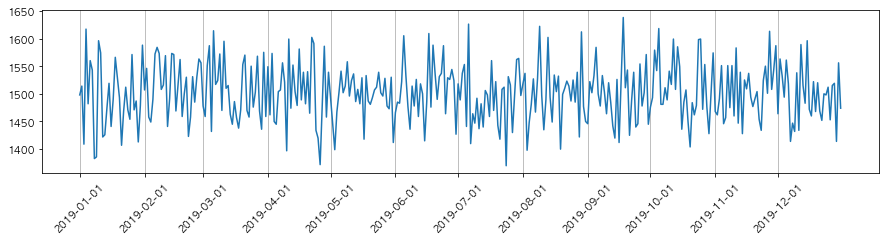

In [5]:
# daily visitors
plt.plot(df['일자'], df['방문자수'])
xtick_range = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]) 
plt.grid(visible = True, which = 'major', axis = 'x')
plt.xticks(ticks = xtick_range, labels = df['일자'].loc[xtick_range], rotation = 45)
plt.show()

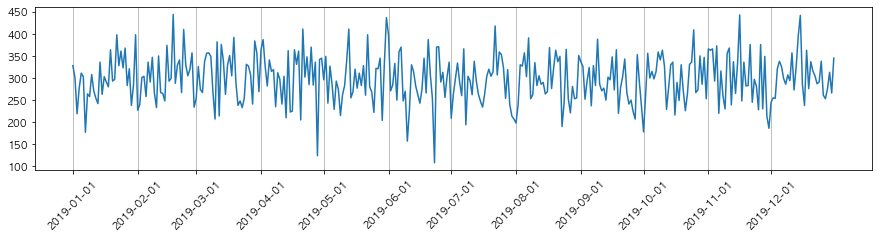

In [6]:
# daily consumers
plt.plot(df['일자'], df['구매자수'])
xtick_range = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]) 
plt.grid(visible = True, which = 'major', axis = 'x')
plt.xticks(ticks = xtick_range, labels = df['일자'].loc[xtick_range], rotation = 45)
plt.show()

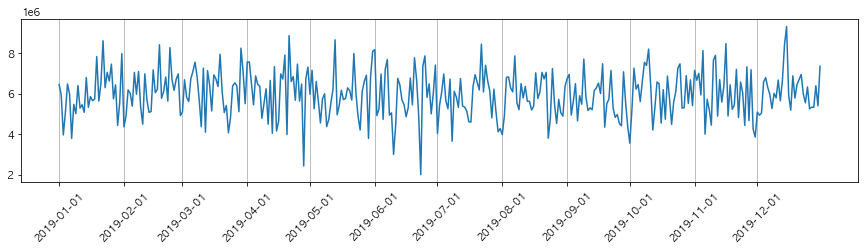

In [7]:
# daily total sales
plt.plot(df['일자'], df['총 판매 금액'])
xtick_range = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]) 
plt.grid(visible = True, which = 'major', axis = 'x')
plt.xticks(ticks = xtick_range, labels = df['일자'].loc[xtick_range], rotation = 45)
plt.show()

## Step 2. 상품 배치와 상품 구매 금액에 따른 관계 분석
상품 배치는 A, B, C로 구성되어있다. 해당 데이터를 각각을 placement_A,B,C로 불러온다.  

고객 ID와 구매금액으로 구성되어있기 때문에 고객 ID를 인덱스로 설정한다.  

- 각각 배치마다 고객 ID가 다른 이유는 각각 다른 집단이기 때문이다.  
    물론 엄밀한 통계분석을 하기 위해서는 같은 고객군에게 보여주어야 효과를 알 수 있다.  
    왜냐하면 각 배치마다 매출이 다르다면, 배치의 문제일 수도 있지만 집단 자체가 달라서 그 특성 때문에 (우연히) 일어난 것일 수도 있기 때문이다.  
- 현실적으로 AB 테스트를 진행할 때 같은 고객들에게 여러개를 보여주는 것은 불가능한 경우가 많기 때문에, 이론적으로만 좋다는 것은 알도록 하자.  



In [9]:
placement_A = pd.read_csv('상품배치_A.csv', encoding = 'cp949', index_col = '고객ID')
placement_A.head()

,구매금액
고객ID,
C-1,20459
C-2,0
C-3,19726
C-4,0
C-5,19049


In [10]:
placement_B = pd.read_csv('상품배치_B.csv', encoding = 'cp949', index_col = '고객ID')
placement_B.head()

,구매금액
고객ID,
C-200,0
C-201,0
C-202,0
C-203,19055
C-204,0


In [11]:
placement_C = pd.read_csv('상품배치_C.csv', encoding = 'cp949', index_col = '고객ID')
placement_C.head()

,구매금액
고객ID,
C-360,0
C-361,19844
C-362,19085
C-363,0
C-364,19671


### 2-1. 구매 금액 0인 경우 제외: 배치에 따른 구매금액 간의 ANOVA 분석 수행
1. 구매금액이 0인 사람 데이터 제외  
    구매금액이 0인 사람과 관련된 데이터 필터링하여 데이터 값만 `.values`를 통해 ndarray형태로 저장하여, 이후 `scipy.stats`를 원할이 사용할 수 있게끔 한다.  
2. 각 데이터 정규분포 충족 여부 확인  
    p-value가 0이기 때문에 0을 제외한 데이터는 정규분포를 따른다. -> 아... 아닌데... 적으면 정규분포를 따르지않을 것이라는 것입니다... 정규분포와 다른 분포일 것이라고요... 물론 정규분포를 따라도 유의한 p값이 나오기도 한다는 것은 맞지만...  
    - 그래서 나름의 그래프를 그려보기로 결정
3. ANOVA 분석
    그룹이 3개 이상이므로 사용.  
    일원분산분석 수행: p-value가 거의 0에 수렴 => A, B, C의 평균은 유의한 차이가 존재  
    (3.382319770772329e-26 -> 10의 26승* 3.38.... 엄청 작다는 것.)  
    즉, 셋 중 하나 이상은 확실히 차이가 있음을 알 수 있다는 것.
4. 사후분석
    결과적으로 B가 다른 그룹과 다르다는 것을 볼 수 있었음.  
    

In [12]:
placement_A_without_zero = placement_A.loc[placement_A['구매금액'] != 0]['구매금액'].values
placement_B_without_zero = placement_B.loc[placement_B['구매금액'] != 0]['구매금액'].values
placement_C_without_zero = placement_C.loc[placement_C['구매금액'] != 0]['구매금액'].values

In [13]:
from scipy.stats import *
print(kstest(placement_A_without_zero, 'norm'))
print(kstest(placement_B_without_zero, 'norm'))
print(kstest(placement_C_without_zero, 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


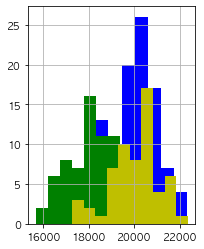

In [15]:
# 정규분포를 따르는게 맞으세요...?
plt.figure(figsize = (3,4))
plt.hist(placement_A_without_zero, color = 'b')
plt.hist(placement_B_without_zero, color = 'g')
plt.hist(placement_C_without_zero, color = 'y')
plt.grid()
plt.show()

In [16]:
print(f_oneway(placement_A_without_zero,
               placement_B_without_zero,
               placement_C_without_zero))

F_onewayResult(statistic=76.88192392994758, pvalue=3.382319770772329e-26)


In [17]:
# 사후 분석 (이 함수는 데이터와 그룹들을 받음)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# 그룹이 정의되어있지 않으니 각 그룹 그 길이에 맞도록 변수를 만듦
Group = ['A'] * len(placement_A_without_zero) + ['B'] * len(placement_B_without_zero) + ['C'] * len(placement_C_without_zero)
Data = placement_A_without_zero.tolist() + placement_B_without_zero.tolist() + placement_C_without_zero.tolist()

print(pairwise_tukeyhsd(Data, Group))

# (A, C) ~ B의 관계임을 확인

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     A      B -1883.1765   -0.0 -2276.2519 -1490.101   True
     A      C    66.7946 0.9221  -343.8753  477.4645  False
     B      C  1949.9711   -0.0  1503.2593 2396.6829   True
-----------------------------------------------------------


### 2-2. 구매 금액 0인 경우 포함: 배치에 따른 구매금액 간의 ANOVA 분석 수행
1. 구매금액이 0인 사람 데이터 포함하여 그대로 사용
2. 각 데이터 정규분포 충족 여부 확인  
    p-value가 거의 0이기 때문에 0을 포함한 데이터도 정규분포를 따른다. 
    -> 아... 아닌데... 적으면 정규분포를 따르지않을 것이라는 것입니다... 정규분포와 다른 분포일 것이라고요... 물론 정규분포를 따라도 유의한 p값이 나오기도 한다는 것은 맞지만...  
    - 그래서 나름의 그래프를 그려보기로 결정
3. ANOVA 분석
    그룹이 3개 이상이므로 사용.  
    일원분산분석 수행: p-value가 0.05 > => A, B, C의 평균은 유의한 차이가 존재
    즉, 셋 중 하나 이상은 확실히 차이가 있음을 알 수 있다는 것.
4. 사후분석
    A와 B는 다른데, A와 C가 비슷하고 C와 B가 비슷하다고 묶였기 때문에 이럴땐 곤란한 상황이다.  
    명확히 하긴 어렵지만, 대략적으로, A와 B,C가 차이가 있다고 볼 수 있다.  
    특히 Meandiff를 이용하여 앞의 그룹이 뒤의 그룹과 얼마나 크거나 작은지를 볼 수 있다.  
    A ~ (B, C) 관계임을 확인

In [18]:
# 각 데이터가 정규분포를 따름을 확인
from scipy.stats import *
print(kstest(placement_A['구매금액'], 'norm'))
print(kstest(placement_B['구매금액'], 'norm'))
print(kstest(placement_C['구매금액'], 'norm'))

KstestResult(statistic=0.5151515151515151, pvalue=2.490817585851874e-49)
KstestResult(statistic=0.5, pvalue=1.6346312024307732e-37)
KstestResult(statistic=0.5, pvalue=9.71661593795993e-35)


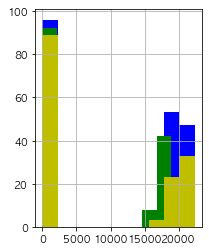

In [19]:
# 정규분포를 따르는게 맞으세요...?
plt.figure(figsize = (3,4))
plt.hist(placement_A['구매금액'], color = 'b', )
plt.hist(placement_B['구매금액'], color = 'g')
plt.hist(placement_C['구매금액'], color = 'y')
plt.grid()
plt.show()

In [20]:
print(f_oneway(placement_A['구매금액'],
               placement_B['구매금액'],
               placement_C['구매금액']))

F_onewayResult(statistic=3.9252421050200677, pvalue=0.020344882530536217)


In [21]:
# 사후 분석
from statsmodels.stats.multicomp import pairwise_tukeyhsd
Group = ['A'] * len(placement_A) + ['B'] * len(placement_B) + ['C'] * len(placement_C)
Data = placement_A['구매금액'].tolist() + placement_B['구매금액'].tolist() + placement_C['구매금액'].tolist()

print(pairwise_tukeyhsd(Data, Group))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     A      B -2602.2773 0.0314 -5020.3131 -184.2414   True
     A      C -2302.0043  0.074 -4773.6625  169.6539  False
     B      C    300.273   0.96 -2293.8963 2894.4423  False
-----------------------------------------------------------


### 2-3. 구매 여부와 상품 배치 간 관계 파악 (카이제곱 검정)

1. 범주형변수 관계분석인 카이제곱 검정을 위해, 각각의 상품 배치 컬럼을 만들어 각 구분을 적어둔다.  
    그리고 행단위로 각 그룹을 붙여서 인덱스를 유지한다. (인덱스가 겹치지 않고, 고객 아이디가 인덱스이기 때문에 구매 여부라는 특별한 정보와 연결되어 있다. 그래서 무시하지 않고 유지한다.)
    구매여부는 구매금액이 0인지 아닌지에 따라서 정할 수 있으므로 구매여부를 1과 0으로 정한다. True면 1로 False면 0이 되도록 `astype(int)`를 사용한다.  

2. 배치에 따른 구매여부를 교차테이블로 만든다. 

3. 카이제곱 검정 수행

In [22]:
# 데이터 변환
placement_A['상품배치'] = 'A'
placement_B['상품배치'] = 'B'
placement_C['상품배치'] = 'C'

placement = pd.concat([placement_A, placement_B, placement_C], axis = 0, ignore_index = False)
placement['구매여부'] = (placement['구매금액'] != 0).astype(int)
placement.head()

,구매금액,상품배치,구매여부
고객ID,,,
C-1,20459,A,1
C-2,0,A,0
C-3,19726,A,1
C-4,0,A,0
C-5,19049,A,1


In [23]:
# 교차 테이블 생성
cross_table = pd.crosstab(placement['상품배치'], placement['구매여부'])
cross_table

구매여부,0,1
상품배치,,
A,96,102
B,92,68
C,89,59


위만 보았을 때는 A 배치가 가장 낫다는 것을 판단할 수 있다. 하지만 정확한 검정을 위해 아래와 같은 카이제곱검정을 수행한다.
이때 pvalue가 0.06으로 0.05보다 크면서, 구매여부와 상품배치에는 관계가 있다고 보기 힘듦.  

    -> 그러나 그 이유는 B와 C의 차이가 크지 않아서 그랬을 뿐, 크로스 테이블을 보면 A가 더 낫다는 것을 확인할 수 있었음.

    -> p값이 정석적이므로 p값을 보되, 통계량이나 데이터를 함께 보아야 더 적확한 해석이 가능하다.  

In [24]:
obs = cross_table.values
statistics, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue) 

0.0686402428247769


In [25]:
# 기대값
pd.DataFrame(expected, columns = cross_table.columns, index = cross_table.index)

구매여부,0,1
상품배치,,
A,108.391304,89.608696
B,87.588933,72.411067
C,81.019763,66.980237


## Step 3. 사이트맵 구성에 따른 체류 시간 차이 분석

배치와 비슷하다. 그러나 각 고객 아이디를 인덱스로 설정하진 않는다. 


In [29]:
sitemap_A = pd.read_csv('사이트맵_A.csv', encoding = 'cp949')
sitemap_A.head()

,고객ID,체류시간(분)
0,C-508,9
1,C-509,8
2,C-510,7
3,C-511,9
4,C-512,10


In [30]:
sitemap_B = pd.read_csv('사이트맵_B.csv', encoding = 'cp949')
sitemap_B.head()

,고객ID,체류시간(분)
0,C-696,10
1,C-697,11
2,C-698,12
3,C-699,10
4,C-700,8


In [31]:
sitemap_C = pd.read_csv('사이트맵_C.csv', encoding = 'cp949')
sitemap_C.head()

,고객ID,체류시간(분)
0,C-820,8
1,C-821,11
2,C-822,10
3,C-823,11
4,C-824,9


### 3-1. 그룹별 평균 체류 시간 비교
그룹별(사이트맵별)로 각각의 시간을 값으로 하여 데이터를 설정하고 평균을 비교한다.

In [32]:
sitemap_A_time = sitemap_A['체류시간(분)'].values
sitemap_B_time = sitemap_B['체류시간(분)'].values
sitemap_C_time = sitemap_C['체류시간(분)'].values

In [33]:
A_mean = sitemap_A_time.mean()
B_mean = sitemap_B_time.mean()
C_mean = sitemap_C_time.mean()

print("사이트 맵 A의 체류시간 평균: {}\n사이트 맵 B의 체류시간 평균: {}\n사이트 맵 C의 체류시간 평균: {}".format(round(A_mean, 3), round(B_mean, 3), round(C_mean, 3)))

사이트 맵 A의 체류시간 평균: 9.404
사이트 맵 B의 체류시간 평균: 9.831
사이트 맵 C의 체류시간 평균: 9.514


### 3-2. 체류시간 값을 boxplot으로 시각화

- boxplot에서 하나의 위치는 각각 정수 1만큼의 차이에 위치하게 된다.  

- 평균은 크게 차이나지 않아보이는데, A의 경우 거의 비슷하고, B는 편차가 있고, 그 편차는 C에서 더욱 커진다. 


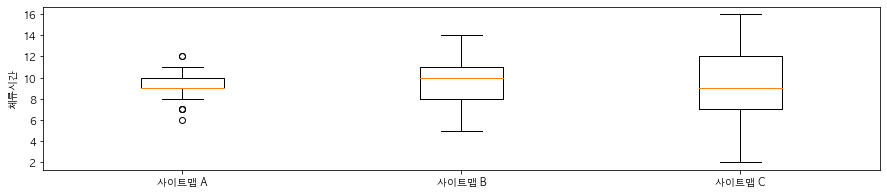

In [34]:
plt.boxplot([sitemap_A_time, sitemap_B_time, sitemap_C_time])
plt.xticks([1, 2, 3], ['사이트맵 A', '사이트맵 B', '사이트맵 C'])
plt.ylabel("체류시간")
plt.show()

### 3-3. 일원분산분석 시행

사이트맵 B가 0.4분 정도 더 많은데 이 시간이 유의미 한 것인지 아닌지 확인하도록 해보자. 

1. 정규분포를 따르는지 검정해보니 0이거나 0에 가까우므로 정규분포를 따른다.  
2. 일원분산분석 수행: p-value가 0.05 초과. 대립가설 기각. 우연에 의한 차이일 뿐이다. 
    => A, B, C의 평균은 유의한 차이가 존재하지 않음을 확인  
    => 사이트맵 배치를 어떻게 해도 크게 차이는 없는 것으로 보이지만, 분포를 보고 도메인 지식에 맞게 배치를 고려해도 좋을 것으로 보임.  



In [35]:
from scipy.stats import *
print(kstest(sitemap_A_time, 'norm'))
print(kstest(sitemap_B_time, 'norm'))
print(kstest(sitemap_C_time, 'norm'))

KstestResult(statistic=0.9999999990134123, pvalue=0.0)
KstestResult(statistic=0.9999997133484281, pvalue=0.0)
KstestResult(statistic=0.9891262924445604, pvalue=1.320331854479069e-206)


In [36]:
print(f_oneway(sitemap_A_time, sitemap_B_time, sitemap_C_time))

F_onewayResult(statistic=1.6538817694924581, pvalue=0.19256727851054653)


## Step 4. 할인 쿠폰의 효과 분석

쌍체 표본 t-검정을 할 예정이다.  

In [37]:
df = pd.read_csv("할인쿠폰발행효과.csv", encoding = "cp949")
df.head()

,고객ID,발행전 구매 횟수,발행후 구매 횟수
0,C-925,3,1
1,C-926,0,0
2,C-927,0,3
3,C-928,0,4
4,C-929,4,4


### 4.1 발행 전후 구매 횟수 차이에 대한 통계 분석

- 발행 하면 1.25 번 정도 더 사는데, 편차가 큰 편이다. 유의한 평균인지 잘 모른다.  
최소값이 -3으로 발행한 후 오히려 안산 경우도 있는 것이다. 

- 통계량만 보는 것은 기계적으로 단순하게 분석할 가능성이 높기 때문에 그래프를 함께 보도록 한다.  
데이터를 이해하기 위해 반드시 수반되어야 하는 과정이다.  

- 만약 두 박스플롯이 전 후의 차이가 각각 75% 위치와 25% 위치가 비슷한 높이일 정도로 박스의 높낮이에 차이가 존재하면 굳이 이후 검정을 수행하지 않아도 차이가 유의미한 것으로 생각하고 생략할 수 있다.  

In [38]:
# type: Series
(df['발행후 구매 횟수'] - df['발행전 구매 횟수']).describe()

count    154.000000
mean       1.259740
std        2.210507
min       -3.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        6.000000
dtype: float64

Text(0, 0.5, '구매 횟수')

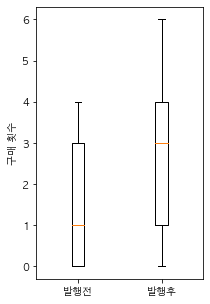

In [40]:
plt.figure(figsize = (3, 5))
plt.boxplot([df['발행전 구매 횟수'], df['발행후 구매 횟수']])
plt.xticks([1, 2], ['발행전', '발행후'])
plt.ylabel("구매 횟수")

### 4.2 쌍체 표본 t-검정

정규성 검정 대상은 차이에 대한 검정이 필요한다. p-value가 매우 작기 때문에 정규분포를 따르는 것이라 알 수 있다.(?) 아니라고  
p-value가 0.05보다 작으므로 두 난수가 같은 분포라는 귀무가설을 기각할 수 있다. 입니다라고요.
(*https://hslee09.medium.com/r-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D-%EC%A0%81%ED%95%A9%EB%8F%84-%EA%B2%80%EC%A0%95-caf48dca9de1* ) 아니 왜 다들 같은 이야기를 하는데 왜 여기서만 그러냐고요....

쌍체 표본 t-test의 결과의 p값이 0.05 미만이므로 차이는 유의미하다, 우연이 아니라고 할 수 있다. 

In [41]:
# 정규성 검정
kstest(df['발행후 구매 횟수'] - df['발행전 구매 횟수'], 'norm')

KstestResult(statistic=0.4253018161037688, pvalue=8.597340234980609e-26)

In [42]:
ttest_rel(df['발행후 구매 횟수'], df['발행전 구매 횟수'])

Ttest_relResult(statistic=7.07211673728211, pvalue=5.104217839308897e-11)

## Step 5. 체류 시간과 구매 금액 간 관계 분석

*체류시간의 단위는 분 단위*



In [43]:
df = pd.read_csv("체류시간_구매금액.csv", encoding = "cp949")
df.head()

,고객ID,구매금액,체류시간
0,C-1079,78625,9
1,C-1080,0,9
2,C-1081,105173,12
3,C-1082,0,14
4,C-1083,0,10


### 5-1. 산점도로 체류시간과 구매금액 연관성 보기

전반적으로 체류시간과 구매금액이 비례하는 경향성을 확인할 수 있다.

<AxesSubplot:xlabel='체류시간', ylabel='구매금액'>

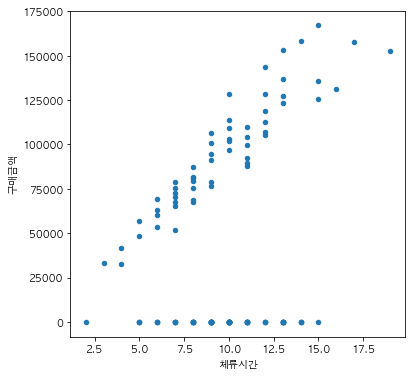

In [52]:
df.plot(kind = 'scatter', x = '체류시간', y = '구매금액', figsize = (6,6))

### 5-2. correlation matrix 확인

선형관계가 있는지 확인해본다.

구매금액이 0이 아닌 데이터만 따로 선형관계를 확인한다.

- 0.3 정도면 약한 선형관계라고 볼 수 있는데, 자연적인 데이터인 것을 감안하면 꽤 높은 수치라고 얘기할 수도 있을 정도이다.  

- 스피어만의 경우 순위간의 관계를 생각하여 비교를 하는데, 구매금액이 큰 순위의 애들이 무조건 체류시간도 순위가 높은가에 따라서는 조금 다르다. 선후관계 보다는 적은 관계성이 있다고 볼 수 있다.  



In [53]:
df.corr(method = 'pearson')

,구매금액,체류시간
구매금액,1.000000,0.320852
체류시간,0.320852,1.000000


In [54]:
df.corr(method = 'spearman')

,구매금액,체류시간
구매금액,1.000000,0.229853
체류시간,0.229853,1.000000


In [55]:
df_without_zero = df.loc[df['구매금액'] != 0]
df_without_zero.corr(method = 'pearson')

,구매금액,체류시간
구매금액,1.000000,0.924526
체류시간,0.924526,1.000000


In [56]:
df_without_zero.corr(method = 'spearman')

,구매금액,체류시간
구매금액,1.000000,0.938099
체류시간,0.938099,1.000000


구매금액이 0이 아닌 데이터만 모았을 때는 엄청나게 강한 양의 상관관계를 보여준다.

따라서 홈페이지에 오래 잡아두는 장치가 필요할 것으로 보인다고 결론을 내릴 수 있다.  

스피어만에서 더 오른 이유는 단순하다. 구매금액이 0인 것들이 순위가 항상 꼴등이기 때문에 분석에 방해가 되었을 것이다. 

## Step 6. 구매버튼 배치에 따른 구매율 차이 분석

1. 데이터 처리
    구매여부에 값이 없는 것이 있다. 값이 없는 것을 확인하기 위해 원 데이터를 확인해 본 결과, xlsx의 셀 병합 때문에 결측행이 생긴 것으로 보인다.  
    결측 행을 처리하기 위해 fillna를 사용한다.  
    방법에 따라 여러 방식으로 결측치를 채우는데 `ffill`이라는 것을 사용하여, 바로 이전의 값들 중 결측이 아닌 값으로 채우는 의미이다.  
    

In [57]:
df = pd.read_excel("구매여부_버튼타입_통계.xlsx")
df.head()

,구매여부,버튼타입,고객 수
0,구매,A,9
1,NaN,B,9
2,NaN,C,15
3,비구매,A,93
4,NaN,B,85


In [58]:
df.fillna(method = 'ffill', inplace = True)
df.head()

,구매여부,버튼타입,고객 수
0,구매,A,9
1,구매,B,9
2,구매,C,15
3,비구매,A,93
4,비구매,B,85


### 6-1. 버튼타입과 구매여부에 따른 고객 수 피봇팅

크로스테이블과 비슷하기 때문에, 이름을 그렇게 지었다고 하셨음... obs는 observation을 뜻한다고(!)

- 데이터 유형에 따라서 크로스탭을 사용할 것인지 피벗테이블을 사용할 것인지 판단을 하는 것도 중요하다.  
지금은 수치들이 있었기 때문에(요약이 되어있기 때문에?) 피봇 테이블을 사용하였다고 했다.  

- pvalue가 0.38로 구매여부와 버튼타입 간에는 관계가 없음을 확인  
안살 사람은 안사는 것으로 수치적으로 확인하였다.

In [59]:
cross_button_buy = pd.pivot_table(df, index = '구매여부', columns = '버튼타입', values = '고객 수')
cross_button_buy

버튼타입,A,B,C
구매여부,,,
구매,9,9,15
비구매,93,85,89


In [60]:
obs = cross_button_buy.values
statistics, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.38033325575735993
